# Twitter Sentiment Analysis

### The objective of this task is to detect hate speech in tweets. We say a tweet contains hate speech if it has a racist or sexist or slur sentiment associated with it. So, the task is to classify racist, sexist or slander  tweets from other tweets. Formally, given a training sample of tweets and labels, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not hate speech. the objective is to predict the labels on the test dataset. Our overall collection of tweets was split in the ratio of 65:35 into training and testing data. Out of the testing data, 30% is public and the rest is private.
##### Source: https://datahack.analyticsvidhya.com/contest/practice-problem-twitter-sentiment-analysis/#ProblemStatement

In [18]:
import pandas as pd
import re 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import spacy
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize , sent_tokenize
from nltk.corpus import stopwords 
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
import sklearn
from wordcloud import WordCloud
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from spacy.lang.en import English

%matplotlib inline

The **test** data file contains only tweet ids and the tweet text with each tweet in a new line.
For **training** the models, we provide a labelled dataset of 31,962 tweets. The dataset is provided in the form of a csv file with each line storing a tweet id, its label and the tweet.
There is 1 test file (public)

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
#First, we need to check tweets to see if there are some irrelevant characters 
pd.set_option('display.max_colwidth', -1)
train["tweet"][1:20]

<ipython-input-3-00c4fb848a4d>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


1     @user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked                     
2       bihday your majesty                                                                                                                          
3     #model   i love u take with u all the time in urð±!!! ðððð
ð¦ð¦ð¦                                                           
4      factsguide: society now    #motivation                                                                                                        
5     [2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo                             
6      @user camping tomorrow @user @user @user @user @user @user @user dannyâ¦                                                                     
7     the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams   #

# Data Cleaning 
### Concatinating the train and test data so both can be clean together: A new column (Dateset) created to indicate where each row belongs

In [4]:
train['Dataset'] = 'train'
test['Dataset'] = 'test'
combi = pd.concat([train, test]).reset_index()
combi.tail()

,index,id,label,tweet,Dataset
49154,17192,49155,NaN,thought factory: left-right polarisation! #trump #uselections2016 #leadership #politics #brexit #blm &gt;3,test
49155,17193,49156,NaN,feeling like a mermaid ð #hairflip #neverready #formal #wedding #gown #dresses #mermaid â¦,test
49156,17194,49157,NaN,"#hillary #campaigned today in #ohio((omg)) &amp; used words like ""assets&amp;liability"" never once did #clinton say thee(word) #radicalization",test
49157,17195,49158,NaN,"happy, at work conference: right mindset leads to culture-of-development organizations #work #mindset",test
49158,17196,49159,NaN,"my song ""so glad"" free download! #shoegaze #newmusic #newsong",test


In [5]:
#Cleaning the tweets

def cleaning_tweet(text):
    # Remove mentions
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    # Remove hashtags
    text = re.sub(r'#(\w+)', '', text)
    # Remove retweets:
    text = re.sub('@user', '', text)
    # Remove urls
    text = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', text)
    # Remove punctuations
    text = re.sub(r'[?!.;:,@-]', '', text)
    # Remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '',text)
    # Remove numbers (digits)
    text = re.sub(r"[\d-]",'',text)
    #
    text = re.sub("[^a-zA-Z]", ' ',text)
    return text

In [6]:
combi['cleaned_tweets'] = combi['tweet'].apply(lambda x: cleaning_tweet(x))

In [7]:
combi.head(10)

,index,id,label,tweet,Dataset,cleaned_tweets
0,0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,train,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction
1,1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,train,thanks for credit i can t use cause they don t offer wheelchair vans in pdx
2,2,3,0.0,bihday your majesty,train,bihday your majesty
3,3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,train,i love u take with u all the time in ur
4,4,5,0.0,factsguide: society now #motivation,train,factsguide society now
5,5,6,0.0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,train,huge fan fare and big talking before they leave chaos and pay disputes when they get there
6,6,7,0.0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦,train,camping tomorrow danny
7,7,8,0.0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl,train,the next school year is the year for exams can t think about that
8,8,9,0.0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦,train,we won love the land
9,9,10,0.0,@user @user welcome here ! i'm it's so #gr8 !,train,welcome here i m it s so


## Tokenization and lemmatization

In [8]:
tokenized_tweet = combi['cleaned_tweets'].apply(lambda x: word_tokenize(x))
tokenized_tweet.head()

0    [when, a, father, is, dysfunctional, and, is, so, selfish, he, drags, his, kids, into, his, dysfunction]
1    [thanks, for, credit, i, can, t, use, cause, they, don, t, offer, wheelchair, vans, in, pdx]            
2    [bihday, your, majesty]                                                                                 
3    [i, love, u, take, with, u, all, the, time, in, ur]                                                     
4    [factsguide, society, now]                                                                              
Name: cleaned_tweets, dtype: object

In [10]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

combi['tokenized_tweet'] = tokenized_tweet
combi['tokenized_tweet'] = combi['tokenized_tweet'].apply(lambda x: [item for item in x if item not in stop_words])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mohsen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
combi.head()

,index,id,label,tweet,Dataset,cleaned_tweets,tokenized_tweet
0,0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,train,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction,"[father, dysfunctional, selfish, drags, kids, dysfunction]"
1,1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,train,thanks for credit i can t use cause they don t offer wheelchair vans in pdx,"[thanks, credit, use, cause, offer, wheelchair, vans, pdx]"
2,2,3,0.0,bihday your majesty,train,bihday your majesty,"[bihday, majesty]"
3,3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,train,i love u take with u all the time in ur,"[love, u, take, u, time, ur]"
4,4,5,0.0,factsguide: society now #motivation,train,factsguide society now,"[factsguide, society]"


In [12]:
#nltk.download('wordnet')
def lemmatize(text):
    result = []
    for item in text:
        lemm = WordNetLemmatizer()
        res = lemm.lemmatize(item)
        result.append(res)
    return result


combi['lemma_tweets'] = combi['tokenized_tweet'].apply(lambda x: lemmatize(x))

In [13]:
combi.head(10)

,index,id,label,tweet,Dataset,cleaned_tweets,tokenized_tweet,lemma_tweets
0,0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,train,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction,"[father, dysfunctional, selfish, drags, kids, dysfunction]","[father, dysfunctional, selfish, drag, kid, dysfunction]"
1,1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,train,thanks for credit i can t use cause they don t offer wheelchair vans in pdx,"[thanks, credit, use, cause, offer, wheelchair, vans, pdx]","[thanks, credit, use, cause, offer, wheelchair, van, pdx]"
2,2,3,0.0,bihday your majesty,train,bihday your majesty,"[bihday, majesty]","[bihday, majesty]"
3,3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,train,i love u take with u all the time in ur,"[love, u, take, u, time, ur]","[love, u, take, u, time, ur]"
4,4,5,0.0,factsguide: society now #motivation,train,factsguide society now,"[factsguide, society]","[factsguide, society]"
5,5,6,0.0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,train,huge fan fare and big talking before they leave chaos and pay disputes when they get there,"[huge, fan, fare, big, talking, leave, chaos, pay, disputes, get]","[huge, fan, fare, big, talking, leave, chaos, pay, dispute, get]"
6,6,7,0.0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦,train,camping tomorrow danny,"[camping, tomorrow, danny]","[camping, tomorrow, danny]"
7,7,8,0.0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl,train,the next school year is the year for exams can t think about that,"[next, school, year, year, exams, think]","[next, school, year, year, exam, think]"
8,8,9,0.0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦,train,we won love the land,"[love, land]","[love, land]"
9,9,10,0.0,@user @user welcome here ! i'm it's so #gr8 !,train,welcome here i m it s so,[welcome],[welcome]


### Let's analyse positive words and the negative ones.

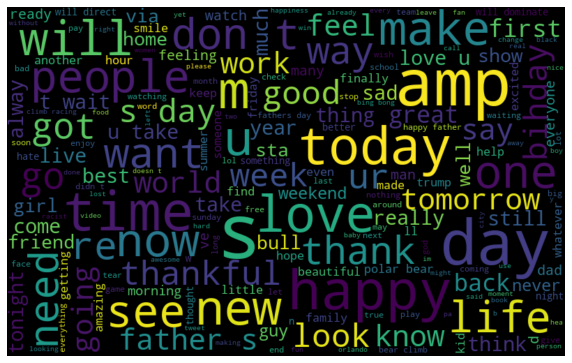

In [19]:
all_words = ' '.join([text for text in combi['cleaned_tweets']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

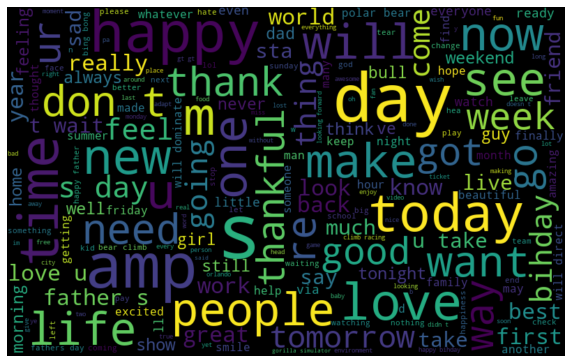

In [20]:
normal_words =' '.join([text for text in combi['cleaned_tweets'][combi['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

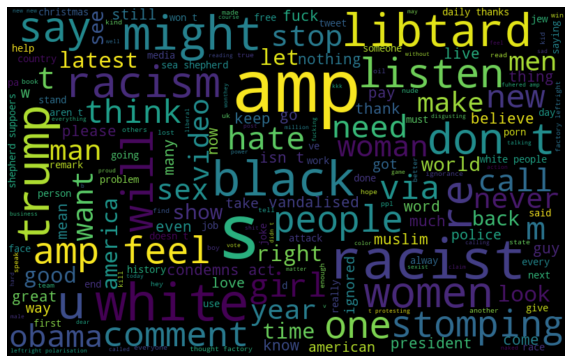

In [21]:
negative_words = ' '.join([text for text in combi['cleaned_tweets'][combi['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [25]:
combi['cleaned_tweets'][combi['label'] == 1]

13         calls  middle school  build the wall  chant                                                    
14       no comment  in                                                                                   
17       retweet if you agree                                                                             
23         lumpy says i am a  prove it lumpy                                                              
34       it s unbelievable that in the st century we d need something like this again                     
                                               ...                                                        
31934    lady banned from kentucky mall                                                                   
31946     omfg i m offended i m a  mailbox and i m proud                                                  
31947      you don t have the balls to hashtag me as a  but you say i am to weasel away lumpy tony dipshit
31948     makes you ask yourself who 

In [26]:
#To find negative words
def neg_words(words):
    for word in words:
        if word in ['n', 'no', 'non', 'not'] or re.search(r"\wn't", word):
            return 1
    else:
        return 0

In [27]:
combi['negatives'] = combi.cleaned_tweets.str.split().apply(lambda x: neg_words(x))

In [28]:
slurs = ['abo', 'Africoon', 'ah tiong', 'albo', 'Americunt','bagel', 'baguette','bean-eater', 'beanbreath', 'beaner', 'blacky', 'Boche',
         'bohunk', 'bong', 'boogie', 'boong', 'boonga', 'booty scratcher', 'brown', 'brownie', 'burrhead', 'cajun', 'camel jockey', 'camelfucker',
         'cape Dutch', 'cheese monkey', 'cheesehead', 'chen', 'chickenlips', 'chimpout', 'chocolate face', 'cholo', 'chopstick', 'Christ-killer', 'chug',
         'clog wog', 'coal burner', 'cockroach', 'coconut', 'conch', 'coon', 'coonass', 'cotton picker', 'cracka', 'cracker', 'cracker-ass', 'crackerass',
         'cracklet', 'crapaud', 'crow', 'crunchie', 'cumskin', 'curry-muncher', 'currycel', 'dago', 'darkey', 'diego', 'dindu nuffin', 'dothead', 'dune coon',
         'durka durka', 'dutch', 'dutchman', 'dutchwoman', 'eyetie', 'farang', 'farm nigger', 'featherwood', 'frogese', 'froggy', 'froglet', 'frogspeak', 'gator bait',
        'giaour', 'ginzo', 'gippo', 'goffel', 'golly', 'goo-goo', 'gook', 'gook wagon', 'gookland', 'goombah', 'grasseater', 'greaseball', 'greaser', 'gringo', 'groid',
        'guat', 'guidette', 'guido', 'guinea','guinea','gussuk','gweilo','gweipo','gyppo','gyppy','gypsyism','hairyback','hajji','half-breed','heeb','heebish','hick',
         'hillbilly','honklet','honky','house nigger','hout','hunky','hymie','injun','jacky','jap','jewfucker','jewtard','jig','jigaboo','jim Crow','johnny Crapaud',
         'judeo-Bolshevik','judeo-Bolshevist','jungle bunny','jungle fever','kaffir','katsap','khokhol','kike','kikey','kimchi','kneegrow','Kraut','Leb','Lebo','limey',
         'mangia-cake','Mangkali','Mat','mayo','mayonnaise face','mean white','mexcrement','mick','moke','mooley','moolie','moolinyan','moon cricket','mud','mud shark',
         'munt','nappyhead','negress','negrette','nep','nig','nig-nog','nigga','nigger','nigger-brown','niggeration','niggerbabble','niggerball','niggerbitch','niggerboy',
         'niggercide','niggerdick']

In [29]:
def slurs_(words, slur_list):
    for word in words:
        if word in slur_list:
            return 1
    else:
        return 0


In [30]:
#To find slurs
combi['slurs'] = combi.cleaned_tweets.str.split().apply(lambda x: slurs_(x, slurs))

In [31]:
Hate_slur = combi[combi["slurs"] >0]
Hate_slur

,index,id,label,tweet,Dataset,cleaned_tweets,tokenized_tweet,lemma_tweets,negatives,slurs
164,164,165,0.0,aww yeah it's all good bing bong bing bong,train,aww yeah it s all good bing bong bing bong,"[aww, yeah, good, bing, bong, bing, bong]","[aww, yeah, good, bing, bong, bing, bong]",0,1
337,337,338,0.0,aww yeah it's all good bing bong bing bong,train,aww yeah it s all good bing bong bing bong,"[aww, yeah, good, bing, bong, bing, bong]","[aww, yeah, good, bing, bong, bing, bong]",0,1
378,378,379,0.0,@user my sister ain't even know i was watching her argue with the nigga ððð was waiting for him too say the wrong shit,train,my sister ain t even know i was watching her argue with the nigga was waiting for him too say the wrong shit,"[sister, even, know, watching, argue, nigga, waiting, say, wrong, shit]","[sister, even, know, watching, argue, nigga, waiting, say, wrong, shit]",0,1
578,578,579,0.0,aww yeah it's all good bing bong bing bong,train,aww yeah it s all good bing bong bing bong,"[aww, yeah, good, bing, bong, bing, bong]","[aww, yeah, good, bing, bong, bing, bong]",0,1
613,613,614,0.0,aww yeah it's all good bing bong bing bong,train,aww yeah it s all good bing bong bing bong,"[aww, yeah, good, bing, bong, bing, bong]","[aww, yeah, good, bing, bong, bing, bong]",0,1
...,...,...,...,...,...,...,...,...,...,...
47792,15830,47793,NaN,aww yeah it's all good bing bong bing bong,test,aww yeah it s all good bing bong bing bong,"[aww, yeah, good, bing, bong, bing, bong]","[aww, yeah, good, bing, bong, bing, bong]",0,1
47856,15894,47857,NaN,happy monday! we're officially going slightly mad with all the coconut love! ð #health #coconut,test,happy monday we re officially going slightly mad with all the coconut love,"[happy, monday, officially, going, slightly, mad, coconut, love]","[happy, monday, officially, going, slightly, mad, coconut, love]",0,1
48112,16150,48113,NaN,can't wait to get my guinea pigs ðð #pets #boys,test,can t wait to get my guinea pigs,"[wait, get, guinea, pigs]","[wait, get, guinea, pig]",0,1
48543,16581,48544,NaN,"you said the wrong thing, nigga. give me your coordinates, i'm trynna run your fade.",test,you said the wrong thing nigga give me your coordinates i m trynna run your fade,"[said, wrong, thing, nigga, give, coordinates, trynna, run, fade]","[said, wrong, thing, nigga, give, coordinate, trynna, run, fade]",0,1


# Modeling and Prediction

In [34]:
cleaned_train = combi.loc[combi['Dataset']=='train']
y = cleaned_train['label']

In [49]:
vectorizer = TfidfVectorizer(max_features=1000)
vectorizer.fit(cleaned_train['cleaned_tweets'])
X = vectorizer.transform(cleaned_train['cleaned_tweets'])

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) #The data is split in the standard 80, 20 ratio

In [51]:
text_classifier = RandomForestClassifier(n_estimators=500, random_state=42)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

In [52]:
predictions = text_classifier.predict(X_test)

In [36]:
print(confusion_matrix(y_test,predictions)) #performance measurement
print(classification_report(y_test,predictions))
print("Accuracy:", accuracy_score(y_test, predictions)*100, "%")

[[5907   78]
 [ 223  185]]
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98      5985
         1.0       0.70      0.45      0.55       408

    accuracy                           0.95      6393
   macro avg       0.83      0.72      0.76      6393
weighted avg       0.95      0.95      0.95      6393

Accuracy: 95.29172532457375 %
